# Relax-Challenge

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import calendar
import datetime as dt
import missingno as ms

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE

In [2]:
user_eng = pd.read_csv('takehome_user_engagement.csv')
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/14 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/13 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/13 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/13 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/13 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


We observe some null-values in 'last_session_creation_time' and 'invited_by_user_id' columns. <br>
It totally makes sense for having null values in 'invited_by_user_id' column because not all users are invited by other existing users

In [5]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


## Data Cleaning.

### Imputing missing values.

In [6]:
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['last_session_creation_time'].mean())

### Changing respective columns into datetime.

In [7]:
user_eng['time_stamp'] = pd.to_datetime(user_eng['time_stamp'])
#users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users['creation_time'] = pd.to_datetime(users['creation_time'])

### Creating target variable.

**"adopted user"** is defined as a user who has logged into the product on three separate days in at least one seven day period. <br> So grouping the visitor logins by week gives us who is an adopted user and who is not. For that we first obtain the week numbers each observation using the time_stamp variable.

In [8]:
user_eng['week_no'] = user_eng['time_stamp'].dt.strftime('%Y-%U')

In [9]:
users_eng_week = pd.DataFrame(user_eng.groupby(['user_id', 'week_no'])['visited'].sum()).reset_index()
users_eng_week.head()

,user_id,week_no,visited
0,1,2014-16,1
1,2,2013-45,1
2,2,2013-47,1
3,2,2013-49,1
4,2,2013-51,1


In [10]:
adopted_users = users_eng_week[users_eng_week['visited'] >= 3]['user_id'].unique()
adopted_users

array([   10,    20,    42, ..., 11969, 11975, 11988])

In [11]:
users['is_adopted'] = users['object_id'].apply(lambda x: 1 if x in adopted_users else 0)

Now that we have our target variable we can do some exploratory analysis to see if there are some interesting patterns.

## Data Exploration.

### Overall Adoption-rate.

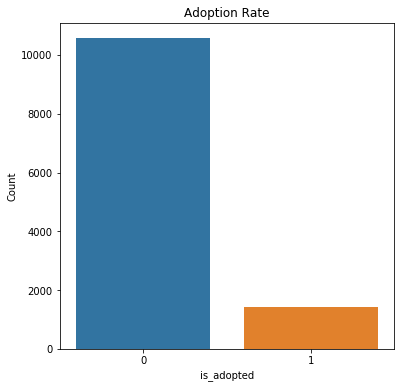

Adoption Percentage: 11.933333333333334


In [12]:
plt.figure(figsize=(6,6))

sns.countplot(x="is_adopted", data=users)
plt.title('Adoption Rate')
plt.xlabel('is_adopted')
plt.ylabel('Count')
plt.show()
print('Adoption Percentage: ' + str(1432/12000 * 100))

The adoption rate is 11.9% which makes it a highly imbalanced classification problem.

### Adoption-rate by creation_source

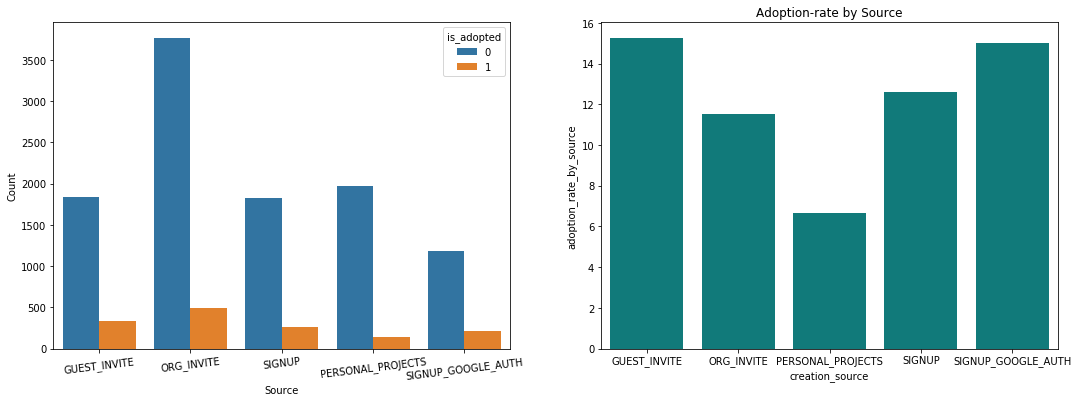

In [13]:
plt.figure(figsize=(18,6))
plt.subplot(121)
sns.countplot(x="creation_source", data = users, hue = 'is_adopted')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation = 7)


plt.subplot(122)
a = users.groupby(['creation_source', 'is_adopted'])['object_id'].count().reset_index()
a = pd.pivot_table(a, values='object_id', index='creation_source',columns='is_adopted')
a['adoption_rate_by_source'] = (a[1]/(a[0] + a[1]))*100
a = a.reset_index()
sns.barplot(x = 'creation_source', y = 'adoption_rate_by_source',data = a, color = 'darkcyan')
plt.title('Adoption-rate by Source')
plt.show()

Users who signed up on a guest invite and google auth tend to have relatively high adoption. 

### Adoption-rate by Mailing List option.

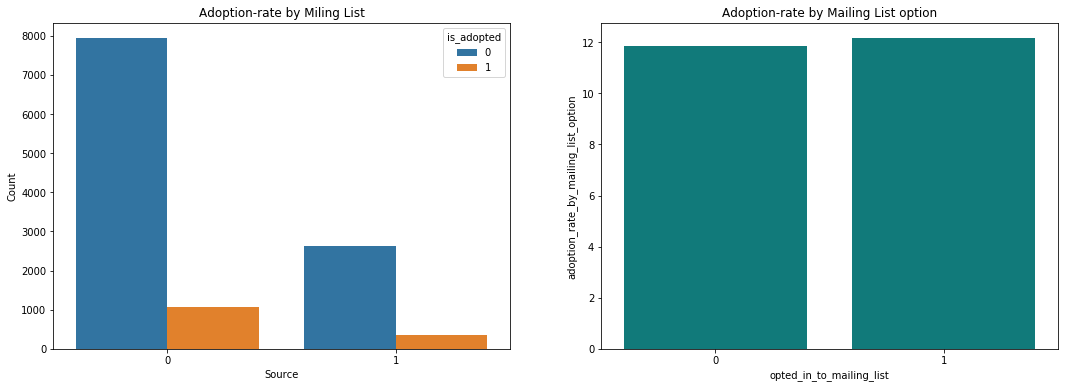

In [14]:
plt.figure(figsize=(18,6))
plt.subplot(121)
sns.countplot(x="opted_in_to_mailing_list", data = users, hue = 'is_adopted')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Adoption-rate by Miling List')

plt.subplot(122)
a = users.groupby(['opted_in_to_mailing_list', 'is_adopted'])['object_id'].count().reset_index()
a = pd.pivot_table(a, values='object_id', index='opted_in_to_mailing_list',columns='is_adopted')
a['adoption_rate_by_mailing_list_option'] = (a[1]/(a[0] + a[1]))*100
a = a.reset_index()
sns.barplot(x = 'opted_in_to_mailing_list', y = 'adoption_rate_by_mailing_list_option',data = a, color = 'darkcyan')
plt.title('Adoption-rate by Mailing List option')
plt.show()

There is not much difference in adoption rate depending on the user choice on mailing list.

### Adoption-rate by Marketing-drip option.

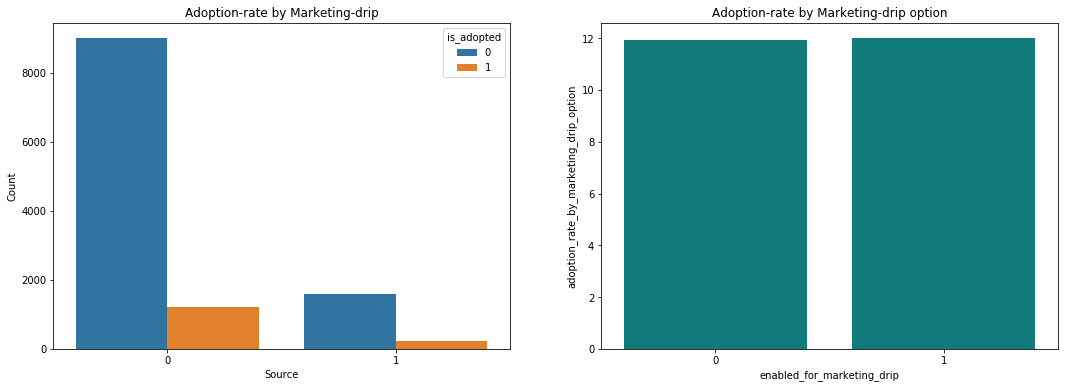

In [15]:
plt.figure(figsize=(18,6))
plt.subplot(121)
sns.countplot(x="enabled_for_marketing_drip", data = users, hue = 'is_adopted')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Adoption-rate by Marketing-drip')

plt.subplot(122)
a = users.groupby(['enabled_for_marketing_drip', 'is_adopted'])['object_id'].count().reset_index()
a = pd.pivot_table(a, values='object_id', index='enabled_for_marketing_drip',columns='is_adopted')
a['adoption_rate_by_marketing_drip_option'] = (a[1]/(a[0] + a[1]))*100
a = a.reset_index()
sns.barplot(x = 'enabled_for_marketing_drip', y = 'adoption_rate_by_marketing_drip_option',data = a, color = 'darkcyan')
plt.title('Adoption-rate by Marketing-drip option')
plt.show()

No difference in adoption rates based in marketing drip option too.

### Adoption Rate by Creation month.

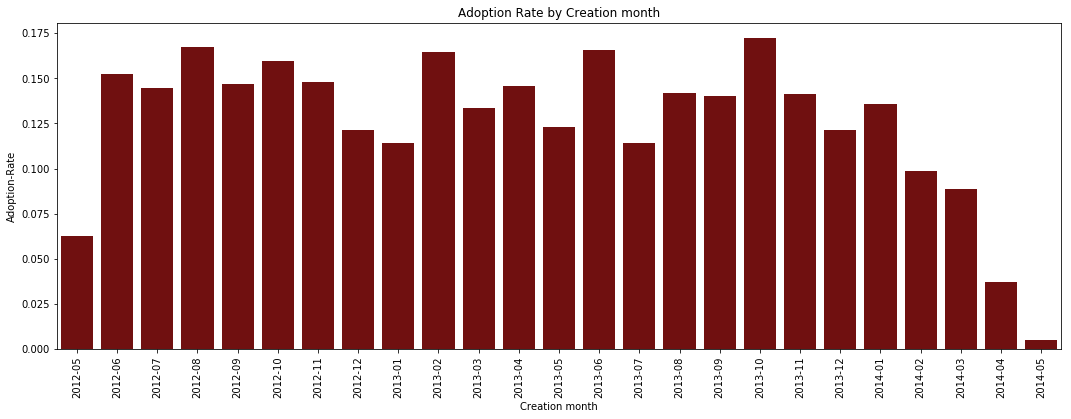

In [16]:
users['creation_month'] = users['creation_time'].dt.strftime('%Y-%m')
x = pd.DataFrame(users.groupby('creation_month')['is_adopted'].mean()).reset_index()

plt.figure(figsize = (18,6))
sns.barplot(x = 'creation_month', y = 'is_adopted', data = x, color = 'maroon')
plt.xticks(rotation = 90)
plt.xlabel('Creation month')
plt.ylabel('Adoption-Rate')
plt.title('Adoption Rate by Creation month')
plt.show()

No clear trend or pattern observed in adoption rate based on time (month considered here) the account was created.

### Adoption rate by email-type. <br>
To see how the adoption rates are based on email-type we are trying to extract the email-domain type using the 'email' column and Since there are 6 major email-types we are replacing all other email-types as 'others.com' so that we have 7 groups of email-types.

In [17]:
users['email_type'] = users['email'].apply(lambda x: x.split('@')[1])

others = ['gmail.com', 'yahoo.com', 'hotmail.com', 'jourrapide.com', 'gustr.com', 'cuvox.de']

users.loc[~users["email_type"].isin(others), 'email_type'] = "other.com"

users['email_type'].value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
other.com         1186
gustr.com         1179
hotmail.com       1165
Name: email_type, dtype: int64

Now that we have replaced all other email-types into 'others.com'. Let's check the adoption rates.

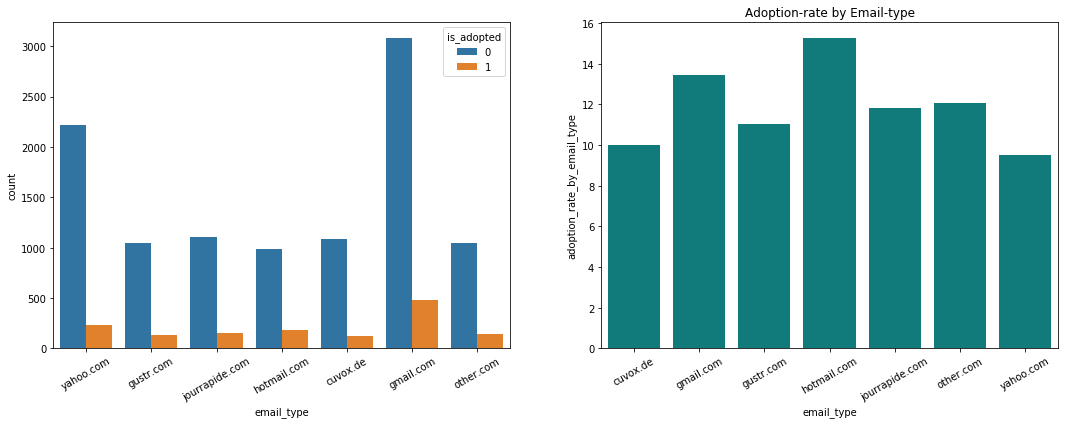

In [18]:
plt.figure(figsize = (18,6))
plt.subplot(121)
sns.countplot(x = 'email_type', data = users, hue = 'is_adopted')
plt.xticks(rotation = 30)

plt.subplot(122)
a = users.groupby(['email_type', 'is_adopted'])['object_id'].count().reset_index()
a = pd.pivot_table(a, values='object_id', index='email_type',columns='is_adopted')
a['adoption_rate_by_email_type'] = (a[1]/(a[0] + a[1]))*100
a = a.reset_index()
sns.barplot(x = 'email_type', y = 'adoption_rate_by_email_type',data = a, color = 'darkcyan')
plt.title('Adoption-rate by Email-type')
plt.xticks(rotation = 30)

plt.show()

Users having hotmail's and gmail's have comparitively little higher adoption rates and **gmail** and **yahoo** are the top 2 most commonly observed email types.

### Adoption rate of users invited by other users.

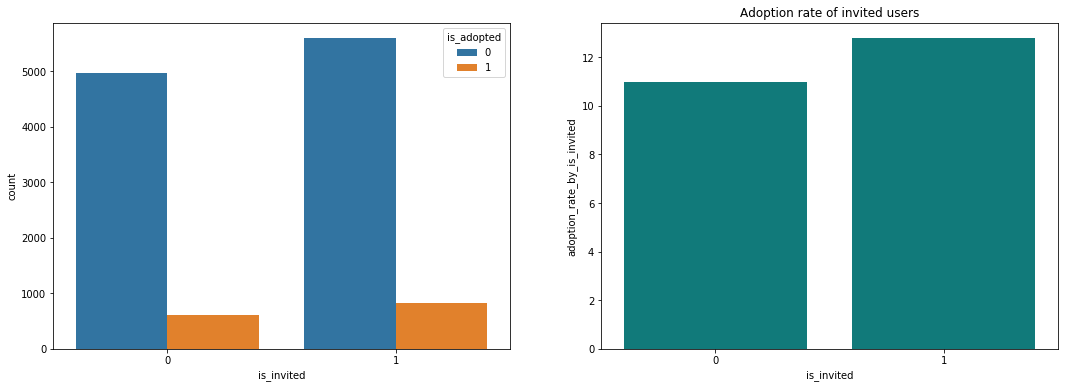

In [19]:
users['invited_by_user_id'] = users['invited_by_user_id'].replace(np.NaN, 0)
users['is_invited'] = users['invited_by_user_id'].apply(lambda x: 1 if x > 0 else 0)

plt.figure(figsize = (18,6))
plt.subplot(121)
sns.countplot(x = 'is_invited', data = users, hue = 'is_adopted')

plt.subplot(122)
a = users.groupby(['is_invited', 'is_adopted'])['object_id'].count().reset_index()
a = pd.pivot_table(a, values='object_id', index='is_invited',columns='is_adopted')
a['adoption_rate_by_is_invited'] = (a[1]/(a[0] + a[1]))*100
a = a.reset_index()
sns.barplot(x = 'is_invited', y = 'adoption_rate_by_is_invited',data = a, color = 'darkcyan')
plt.title('Adoption rate of invited users')
plt.show()

We observe that the invited users have a higher adoption rate.

### Organisation Id's.

We have users coming from **417** different organisations.**

## Data Pre-processing.

In [20]:
users = users.drop(['object_id', 'creation_time', 'name', 'email', 'invited_by_user_id'], axis = 1)

In [21]:
users['creation_month'] = users['creation_month'].astype('category')
users['opted_in_to_mailing_list'] = users['opted_in_to_mailing_list'].astype('category')
users['enabled_for_marketing_drip'] = users['enabled_for_marketing_drip'].astype('category')
users['is_invited'] = users['is_invited'].astype('category')
users['creation_source'] = users['creation_source'].astype('category')
users['email_type'] = users['email_type'].astype('category')

In [22]:
users = pd.get_dummies(users)

X,y = users.drop(['is_adopted'], axis=1), users['is_adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 12, stratify = y)

### SMOTE.

Because we have very less number of samples from one class we try to do oversampling using SMOTE so that our model has enough samples to learn patterns from both the classes equally.

In [23]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/Users/dineshviswatejagurram/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


## Model Building.

In [24]:
dt = DecisionTreeClassifier()
dt.fit(X_train_res, y_train_res)
y_pred_dt = dt.predict(X_test)
print('Decision Tree Classifier Accuracy : ' + str(accuracy_score(y_test, y_pred_dt)))

rf = RandomForestClassifier()
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
print('Random Forest Classifier Accuracy : ' + str(accuracy_score(y_test, y_pred_rf)))

gbc = GradientBoostingClassifier()
gbc.fit(X_train_res, y_train_res)
y_pred_gbc = gbc.predict(X_test)
print('Gradient-Boosting Classifier Accuracy : ' + str(accuracy_score(y_test, y_pred_gbc)))

Decision Tree Classifier Accuracy : 0.9595833333333333
Random Forest Classifier Accuracy : 0.9608333333333333
Gradient-Boosting Classifier Accuracy : 0.965


### Feature importance plot.

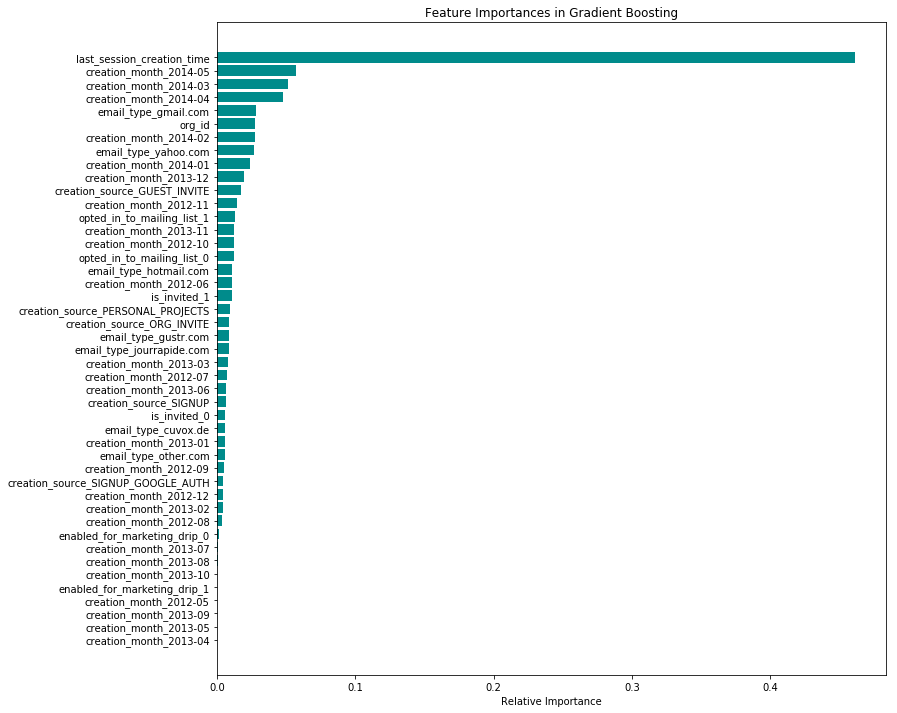

In [25]:
plt.figure(figsize=(12,12))
features = X_train.columns
importances = gbc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances in Gradient Boosting')
plt.barh(range(len(indices)), importances[indices], color='darkcyan', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

#### Conclusion:
Finally from the feature importance chart we can say that **'last_session_creation_time'** is the most important predictor in predicting an adopted user. And also the **creation_month** seems to be second best predictor.